# Prediccion de Ventas en una Serie de Tiempo

## Forecasting in Time Series

Objetivo: Predecir un año de Ventas dados 6 años de datos (Periodicidad Mensual), aplicando conceptos de Series de Tiempo y algoritmos de forecasting en Aprendizaje No Supervisado

## Pasos:
### 0. Preparacion Hardware-Software
Requerimientos:
Python 3.6, Anaconda, Keras, Tensorflow, Scikit Learn, Scipy.

##### Comandos para instalar desde un Anaconda Prompt:
`conda create -n prediccionventas python=3.6 numpy scipy matplotlib spyder pandas
activate prediccionventas `
#computador sin gpu

`pip install --ignore-installed --upgrade tensorflow`
#computador GPU

`pip install --ignore-installed --upgrade tensorflow-gpu`
`conda install mkl-service m2w64-toolchain`
`pip install pydot keras`
> Si existe problemas por las versiones de las librerias, se recomienda importar el ambiente Conda del repositorio, el cual tiene los requerimientos configurados https://github.com/FreddieAbad/PrediccionAUCORP/tree/master/Entrega/Ambiente%20Conda

### 1. Obtencion de datos
No Aplica, los datos fueron proveidos. 
### 2. Preparar los datos
Los atributos de la data corresponden a un total de 16 atributos, correspondientes a fechas, ventas, y variaciones estadísticas útiles para el fin de este proyecto.


In [112]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from matplotlib.pyplot import figure

import matplotlib.pyplot as plt

In [94]:
# cargamos el conjunto de datos
dataframe = read_csv('base_datos_ventas2.csv', sep=';')
dataset = dataframe.columns
print(dataset)

Index(['mes de analisis', 'Año', 'CATEGORIA', 'CANTIDAD_CLASIF_A',
       'ventas_totales_Veh_livianos', 'Tasa de inflación (mensual)',
       'Población Económicamente Activa (Nacional)',
       'Exportaciones totales (USD)',
       'PRODUCTO INTERNO BRUTO (PIB) TRIMESTRAL (MILES DE DOL)',
       'Balanza comercial total (millones de usd)',
       ' Valor Unitario del petroleo Promedio (eje der.) ',
       'EXPORTACIONES PETROLERAS (miles de USD) FOB (der)',
       'Import. CIF MILLONES USD', 'Exp. no petroleras MILLONES USD',
       'IMPORTACIONES Petroleras', 'IMPORTACIONES No Petroleras'],
      dtype='object')


Para seguir el proceso, se necesita entender los atributos y sus variaciones, por tanto se muestra a continuacion las graficas de los atributos en los cuales el negocio tiene una afeccion directa (CANTIDAD_CLASIF_A, Ventas de vehiculos livianos, Tasa Inflacion). Los demás atributos no, ya que no dependen directamente del negocio, sino del variables que dicta la situacion del pais.

#### Gráficas de cada atributo a travez del tiempo

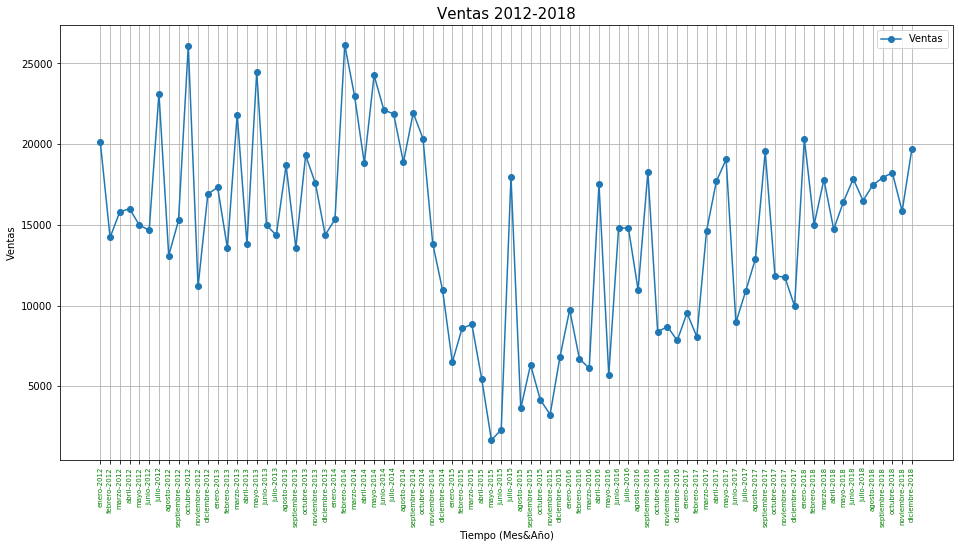

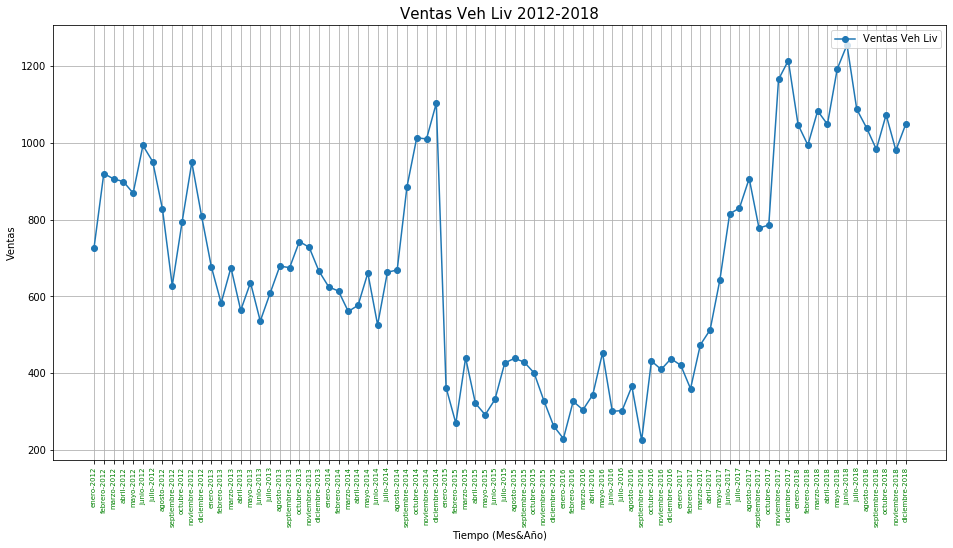

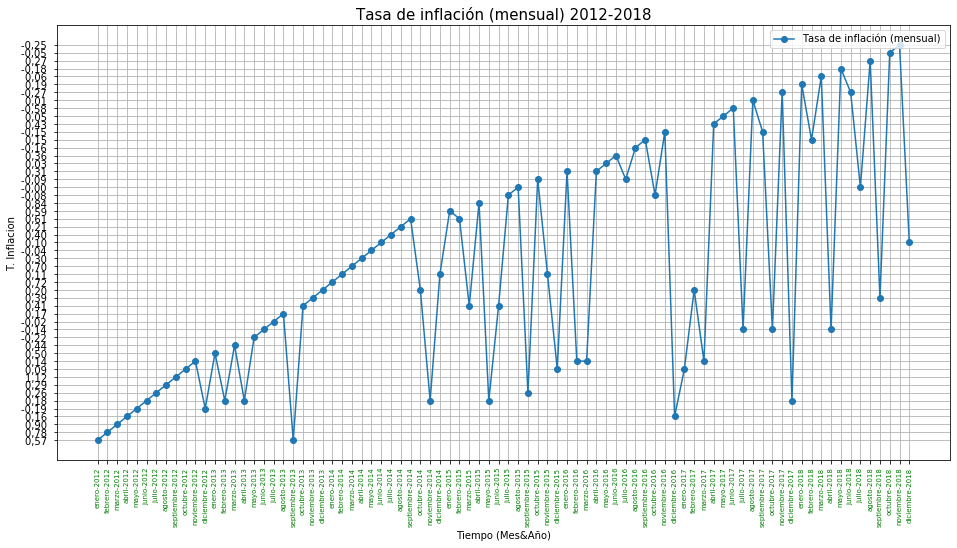

In [95]:
def graficaAtributo(atributo,nombreLeyenda,titulo,xetiqueta,yetiqueta,nombreArchivo):
    figure(figsize=(16,8))
    dataframe['mes de analisis'] = dataframe['mes de analisis'].astype(str)
    dataframe['Año'] = dataframe['Año'].astype(str)
    plt.plot(dataframe['mes de analisis']+'-'+dataframe['Año'], dataframe[atributo], "-o")
    plt.legend([nombreLeyenda], loc = 'upper right')
    plt.grid(True)
    plt.title(titulo, fontsize = 15)
    plt.xlabel(xetiqueta, fontsize = 10)
    plt.ylabel(yetiqueta, fontsize = 10)
    plt.xticks(fontsize=7, color = 'g', rotation = 90) 
    plt.savefig(nombreArchivo, dpi=300)
#Grafica del atributo a predecir
graficaAtributo('CANTIDAD_CLASIF_A','Ventas',"Ventas 2012-2018","Tiempo (Mes&Año)","Ventas",'ventasGrafica.svg')
#Grafica de Venta de Vehiculos livianos
graficaAtributo('ventas_totales_Veh_livianos','Ventas Veh Liv',"Ventas Veh Liv 2012-2018","Tiempo (Mes&Año)","Ventas",'ventas_totales_Veh_livianos.svg')
#Grafica de Venta de Vehiculos livianos
graficaAtributo('Tasa de inflación (mensual)','Tasa de inflación (mensual)',"Tasa de inflación (mensual) 2012-2018","Tiempo (Mes&Año)","T. Inflacion",'t_inflacion.svg')



##### Se debe reducir la dimensionalidad de los datos, evitando atributos innecesarios (aplicacion de PCA)
El atributo Categoria no muestra valores influyentes en nuestra data, se mantiene el valor "A", si el modelo a entrenar toma en cuenta este atributo, se malgastarian recursos. El atributo Mes y Año se unen en un solo atributo, ya que al ser una serie de tiempo, estos dos fijan los demas valores a un solo valor en el tiempo.

### Pendiente
Se aplica PCA, para obtener atributos netamente necesarios e independientes de otros atributos.
#### ====
> Principal Component Analysis es una técnica de Extracción de Características donde se combinan las entradas de una manera específica, para eliminar algunas de las variables «menos importantes» manteniendo la parte más importante todas las variables. Luego de aplicar PCA, todas las nuevas variables son independientes una de otra.
#### ====
La data se normaliza y estandariza, los modelos se entrenaran con estos dos datos y con los datos originales, para conocer cual da un mejor resultado.

##### Estandarización 
Refiere al desplazamiento de la distribución de cada atributo para tener una media de cero y una desviación estándar de uno (varianza unitaria).Es útil estandarizar atributos para un modelo que se basa en la distribución de atributos como los procesos gaussianos.
##### Normalización 
Refiere a reescalar atributos numéricos de valor real en el rango 0 y 1. Es útil escalar los atributos de entrada para un modelo que se basa en la magnitud de los valores, como las medidas de distancia utilizadas en los vecinos k más cercanos y en la preparación de coeficientes de regresión.

In [96]:
#Eliminacion de Atributos Innecesarios & Fusion Atributo Mes-Año
dataframe['mes de analisis'] = dataframe['mes de analisis'].astype(str)
dataframe['Año'] = dataframe['Año'].astype(str)
dataframe['Fecha']= dataframe['mes de analisis']+'-'+dataframe['Año']
dataframe=dataframe.drop(columns=['mes de analisis', 'Año','CATEGORIA'])



In [97]:
#Preprocesamiento de los datos, para posteriormente Normalizarlo (Al no realizarlo se trata como un string, y no como un Float32)
from sklearn.preprocessing import LabelEncoder
for column in dataframe.columns:
    if dataframe[column].dtype == type(object):
        le = LabelEncoder()
        dataframe[column] = le.fit_transform(dataframe[column])


In [98]:
#Normalizacion
from sklearn import preprocessing
import pandas
X = dataframe.values
normalized_X = preprocessing.normalize(X)
dataframeNormalize = pandas.DataFrame(normalized_X, columns = dataframe.columns)  
#print(dataframeNormalize)
#print(normalized_X)
export_csv = df.to_csv (r'dataframeNormalize.csv', index = None, header=True)


In [99]:
#Standarizacion
from sklearn import preprocessing
Z = dataframe.values
standardized_X = preprocessing.scale(Z)
dataframeStandarized = pandas.DataFrame(standardized_X, columns = dataframe.columns)  
#print(dataframeNormalize)
#print(standardized_X)
export_csv = df.to_csv (r'dataframeStandarized.csv', index = None, header=True)


In [100]:
### 2.1 Separacion de datos segun la Regla de Pareto 80/20.


In [104]:
from sklearn.model_selection import train_test_split
traindfStandarize, testdfStandarize = train_test_split(dataframeStandarized, test_size=0.2)
traindfNormalize, testdfNormalize = train_test_split(dataframeNormalize, test_size=0.2)
traindfOriginal, testdfOriginal = train_test_split(dataframe, test_size=0.2)
print ("Verificacion de valores train - test ")
print (str(traindfStandarize.shape) + ' & '+str(testdfStandarize.shape))
print (str(traindfNormalize.shape) + ' & '+str(testdfNormalize.shape))
print (str(traindfOriginal.shape) + ' & '+str(testdfOriginal.shape))

Verificacion de valores train - test 
(67, 14) & (17, 14)
(67, 14) & (17, 14)
(67, 14) & (17, 14)


> Los datos estan limpios, se puede proceder con los modelos de entrenamiento
### 3. Elegir el modelo
Al ser un problema de prediccion, se puede operar mediante varios algoritmos, sin embargo, uno de los requerimientos fue el realizarlo mediante un **Perceptron Multicapa (MLP)**.
Si bien, es posible realizarlo por una MLP, los errores usualmente suelen ser grandes, por tal se procedera a realizar 3 casos de estudio con 3, 5, 11 capas intermedias.
Las series de tiempo suelen tener mejores resultados con otro tipo de algoritmos, tales como los **LSTM (Long short-term memory)**, **RNN(Recurrent Neural Network)** . 
Se realizara tambien la prediccion con estos algoritmos, y finalmente se procedera a contrastar los resultados, para conocer cual fue el mejor método.

### 4. Desarrollo Modelos
Previamente se pudo realizar la prediccion mediante el software WEKA. De los caules se obtuvieron los siguientes resultados:
##### Caso 1
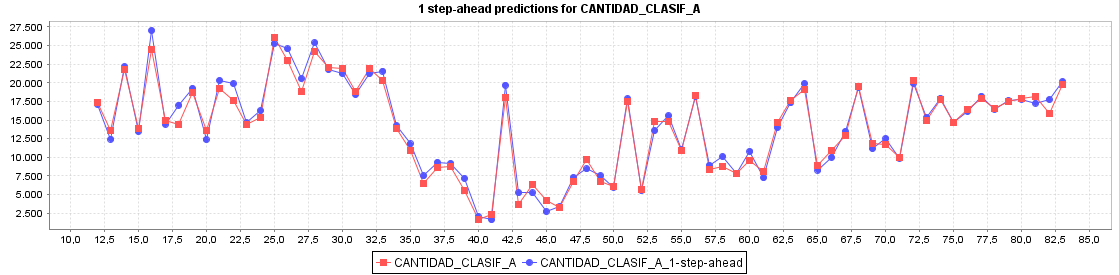
      

| Mes | Prediccion CANTIDAD_CLASIF_A |
| :-------------: | :-------------: |
| Enero 2019 | 19539.9719 |
| Febrero 2019 | 16205.9172 |
| Marzo 2019 | 3774.9766 |
| Abril 2019 | 21806.4895 |
| Mayo 2019 | 33265.9147 |
| Junio 2019 | 26336.9169 |
| Julio 2019 | 23226.3605 |
| Agosto 2019 | 29075.6198 |
| Septiembre 2019 | 39265.0998 |
| Octubre 2019 | 38623.6279 |
| Noviembre 2019 | 24892.4676 |
| Diciembre 2019 | 9921.7544 |         

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

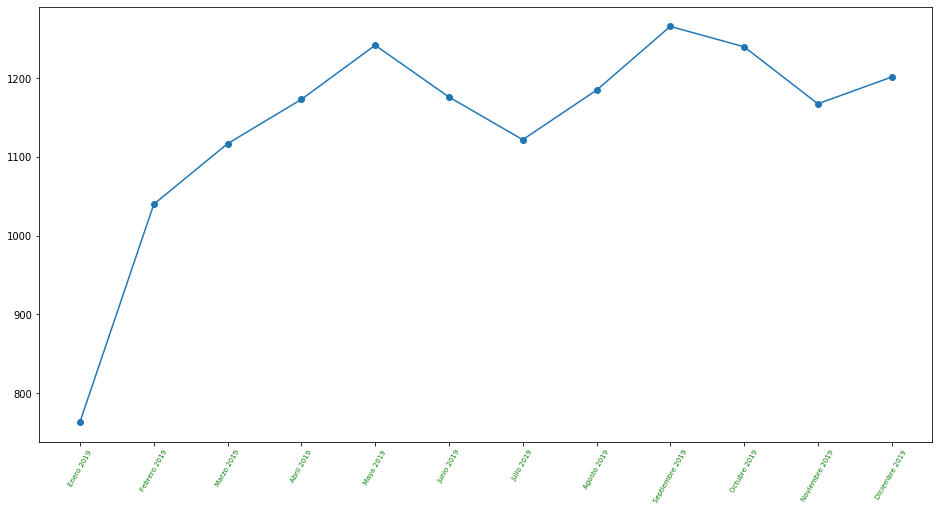

In [116]:
### Error
meses=["Enero 2019","Febrero 2019","Marzo 2019","Abril 2019","Mayo 2019","Junio 2019","Julio 2019","Agosto 2019","Septiembre 2019","Octubre 2019","Noviembre 2019","Diciembre 2019"] 
mae=[763.4624,1039.8887, 1116.745,1172.9777,1241.7909,1175.9647, 1121.783,1184.7128,1265.7152,  1239.83,1167.4088,1201.3861]
figure(figsize=(16,8))
plt.plot(meses, mae, "-o")
plt.xticks(fontsize=7, color = 'g', rotation = 60) 


##### Caso 2
Configuracion: Learning Rate 0.1 Epocas 20 Hidden Layers 20

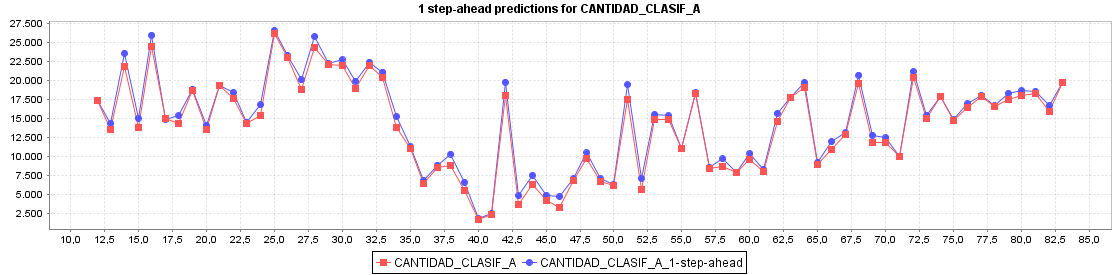

| Mes | Prediccion CANTIDAD_CLASIF_A |
| :-------------: | :-------------: |
| Enero 2019 | 16698.862 |
| Febrero 2019 | 19353.6774 |
| Marzo 2019 | 14024.0933 |
| Abril 2019 | 22657.4798 |
| Mayo 2019 | 23203.0621 |
| Junio 2019 | 16955.6281 |
| Julio 2019 | 18131.2674 |
| Agosto 2019 | 16285.8306 |
| Septiembre 2019 | 15794.0808 |
| Octubre 2019 | 11088.6973 |
| Noviembre 2019 | 12406.8213 |
| Diciembre 2019 | 10055.6109 |  

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

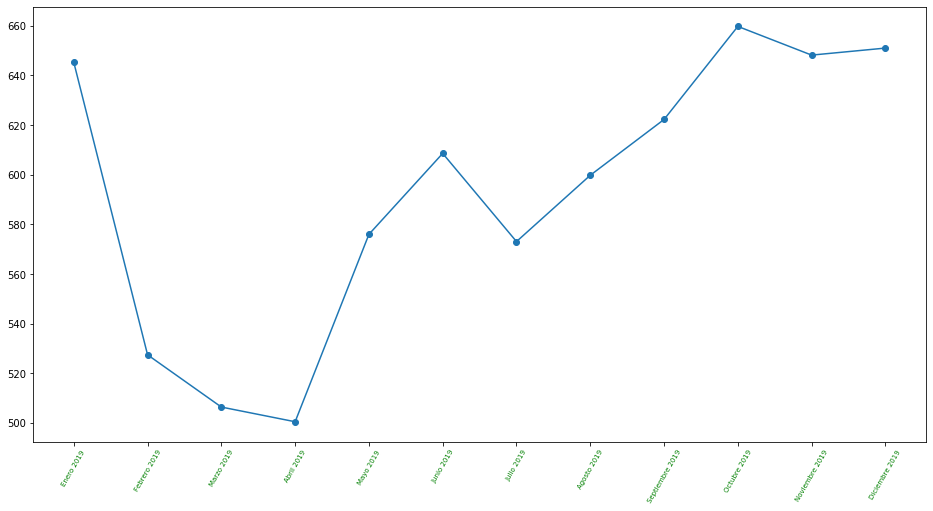

In [119]:
### Error
meses=["Enero 2019","Febrero 2019","Marzo 2019","Abril 2019","Mayo 2019","Junio 2019","Julio 2019","Agosto 2019","Septiembre 2019","Octubre 2019","Noviembre 2019","Diciembre 2019"] 
mae=[645.2398,527.4249,506.3839,500.4671,575.9494,608.5537,573.0385,599.7472,622.2249,659.7058,648.1423,650.9735]
figure(figsize=(16,8))
plt.plot(meses, mae, "-o")
plt.xticks(fontsize=7, color = 'g', rotation = 60) 

Se evidencia los errores extremadamente grandes, para tener un mayor control se procede a realizar las **MLP** por python para configurar mas caracteristicas a "mano".

### Configuracion de MLP
##### Descripción Arquitectura 
Red neuronal FeedForward o MLP - Multi-Layered Perceptron, con método de activación tangente hiperbólica pues hay valores transformados entre -1 y 1.

In [ ]:
### 5. Evaluación
### 6. Parameter Tuning (configuración de parámetros)
### 7. Predicción o Inferencia